<a href="https://colab.research.google.com/github/eshnil2000/google-colab/blob/master/single_notebook_contract_interaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import required modules & files
%rm -rf /content/google-colab/
!git clone https://github.com/eshnil2000/google-colab.git
%cd google-colab
!brownie compile

import web3
from web3 import Web3
web3 = Web3(Web3.HTTPProvider("http://localhost:8545",request_kwargs={'timeout':60}))
web3.isConnected()

import config as cfg
cfg.DEBUG='TRUE'
import json

#Read in the contract
with open('contracts/Danku_demo_final.json') as json_file:  
    data = json.load(json_file)


Cloning into 'google-colab'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 354 (delta 40), reused 0 (delta 0), pack-reused 265
Receiving objects: 100% (354/354), 31.73 MiB | 33.77 MiB/s, done.
Resolving deltas: 100% (169/169), done.
/content/google-colab
Brownie v1.0.0b10 - Python development framework for Ethereum

Using solc version v0.4.19
Compiling contracts...
Optimizer: Enabled  Runs: 200
Generating build data...
 - Danku_demo_final...
Brownie project has been compiled at /content/google-colab/build/contracts


In [0]:
#Prepare the contract for deployment
web3.eth.defaultAccount=web3.eth.accounts[1]
myContract = web3.eth.contract(abi=data['abi'], bytecode=data['bytecode'])


In [0]:
tx_hash=myContract.constructor().transact()

In [0]:
#Confirmation of contract deployment
tx_receipt = web3.eth.waitForTransactionReceipt(tx_hash)

In [0]:
# Create a handle to the contract instance with the newly-deployed address
myContractaddress = web3.eth.contract(
    address=tx_receipt.contractAddress,
    abi=data['abi'],
)

In [0]:
#Install modules to read in training data, prepare Neural Network
from dutils.dataset import DemoDataset
from dutils.neural_network import NeuralNetwork
import dutils.debug as dbg
from secrets import randbelow
from matplotlib import pyplot as plt
import numpy as np

In [0]:
#Split data into training & test sets
scd = DemoDataset(training_percentage=0.8,partition_size=5)
#Generate Unique number for each partition
scd.generate_nonce()
#COmpute the unique hash of each group of data in each of the partitions
scd.sha_all_data_groups()


In [34]:
print("The input data is\n",scd.data)
print("The data is of length:", len(scd.data), " and split up into ",scd.num_data_groups, " data partitions")
print("Each partition has a nonces/unique number \n",scd.nonce)
print("Hashed byte value of each partition \n")
print(scd.hashed_data_group)
print("The number of training groups\n",scd.num_train_data_groups)
print("Training data in format (latitude,longitude,party_voted):")
print(scd.train_data)

The input data is
 [(31569243, -103006747, 1), (36931166, -76239720, 0), (34675090, -78044929, 1), (41775934, -94357971, 1), (40036673, -98069593, 1), (30914247, -91098267, 1), (36442431, -78557098, 1), (36379479, -79366733, 1), (29297302, -97047148, 1), (35936934, -76203339, 1), (31762219, -83876179, 1), (30901690, -89820725, 1), (31689973, -84327480, 0), (31212878, -83412143, 1), (36690661, -93344687, 1), (40280531, -74712018, 0), (42480150, -76946931, 1), (35504165, -86792003, 1), (40495710, -81216271, 1), (30383156, -85515060, 1), (30025584, -85215173, 1), (41772503, -91132480, 1), (48940067, -111849008, 1), (40306854, -92085363, 1), (45567085, -104539066, 1), (33495794, -97143184, 1), (41027277, -76653633, 1), (34310191, -96670349, 1), (41685744, -81672797, 0), (46315267, -119371393, 1), (39165152, -108076508, 1), (44330169, -86027194, 1), (37092605, -108125194, 0), (34155253, -78055776, 1), (36311201, -78922920, 1), (41396988, -75186881, 1), (37368042, -102265146, 1), (32257831, 

In [0]:
offer_account = web3.eth.accounts[1]
solver_account = web3.eth.accounts[2]
_hashed_data_groups = []
accuracy_criteria = 5000 # 50.00%
#total_gas_used = 0
timeout = 180
w_scale = 1000 # Scale up weights by 1000x
b_scale = 1000 # Scale up biases by 1000x

In [0]:
init1_tx=myContractaddress.functions.init1(scd.hashed_data_group, accuracy_criteria,offer_account)
init1_tx_hash=init1_tx.transact()

init2_tx=myContractaddress.functions.init2().transact()


In [0]:
# Get training & testing partition numbers from the Contract. These are randomly generated on the contract
training_partition = list(map(lambda x: myContractaddress.functions.training_partition(x).call(),range(scd.num_train_data_groups)))
testing_partition = list(map(lambda x: myContractaddress.functions.training_partition(x).call(),range(scd.num_test_data_groups)))
scd.partition_dataset(training_partition, testing_partition)


In [11]:
def scale_packed_data(data, scale):
    # Scale data and convert it to an integer
    return list(map(lambda x: int(x*scale), data))

training_nonces = []
training_data = []
for i in training_partition:
    training_nonces.append(scd.nonce[i])
# Pack data into a 1-dimension array
# Since the data array is too large, we're going to send them in single data group chunks
train_data = scd.pack_data(scd.train_data)
test_data = scd.pack_data(scd.test_data)

init3_tx = []
for i in range(len(training_partition)):
    start = i*scd.dps*scd.partition_size
    end = start + scd.dps*scd.partition_size
    dbg.dprint("(" + str(training_partition[i]) + ") Train data,nonce: " + str(train_data[start:end]) + "," + str(scd.train_nonce[i]))
    iter_tx = myContractaddress.functions.init3(train_data[start:end], scd.train_nonce[i])
    iter_receipt = iter_tx.transact()
    init3_tx.append(iter_tx)


(1) Train data,nonce: [30914247, -91098267, 1, 36442431, -78557098, 1, 36379479, -79366733, 1, 29297302, -97047148, 1, 35936934, -76203339, 1],3441994498

(7) Train data,nonce: [41396988, -75186881, 1, 37368042, -102265146, 1, 32257831, -85129772, 0, 34965525, -100814865, 1, 32378209, -101612630, 1],2376477371

(5) Train data,nonce: [33495794, -97143184, 1, 41027277, -76653633, 1, 34310191, -96670349, 1, 41685744, -81672797, 0, 46315267, -119371393, 1],3315424871

(4) Train data,nonce: [30025584, -85215173, 1, 41772503, -91132480, 1, 48940067, -111849008, 1, 40306854, -92085363, 1, 45567085, -104539066, 1],274457994

(8) Train data,nonce: [37534736, -122325880, 0, 37119566, -90444953, 1, 41232908, -120507888, 1, 40712900, -91238190, 1, 46577941, -119162115, 1],1629934853

(9) Train data,nonce: [44063604, -116750704, 1, 33895272, -80498019, 0, 33331905, -91297702, 0, 26763312, -81438833, 1, 27297687, -97787713, 0],949686412

(6) Train data,nonce: [39165152, -108076508, 1, 44330169, -860

In [12]:
# Get the training data from the contract
contract_train_data_length = myContractaddress.functions.get_train_data_length().call()
contract_train_data = []
for i in range(contract_train_data_length):
    for j in range(scd.dps):
        contract_train_data.append(myContractaddress.functions.train_data(i,j).call())
contract_train_data = scd.unpack_data(contract_train_data)
dbg.dprint("Contract training data: " + str(contract_train_data))

Contract training data: [(30914247, -91098267, 1), (36442431, -78557098, 1), (36379479, -79366733, 1), (29297302, -97047148, 1), (35936934, -76203339, 1), (41396988, -75186881, 1), (37368042, -102265146, 1), (32257831, -85129772, 0), (34965525, -100814865, 1), (32378209, -101612630, 1), (33495794, -97143184, 1), (41027277, -76653633, 1), (34310191, -96670349, 1), (41685744, -81672797, 0), (46315267, -119371393, 1), (30025584, -85215173, 1), (41772503, -91132480, 1), (48940067, -111849008, 1), (40306854, -92085363, 1), (45567085, -104539066, 1), (37534736, -122325880, 0), (37119566, -90444953, 1), (41232908, -120507888, 1), (40712900, -91238190, 1), (46577941, -119162115, 1), (44063604, -116750704, 1), (33895272, -80498019, 0), (33331905, -91297702, 0), (26763312, -81438833, 1), (27297687, -97787713, 0), (39165152, -108076508, 1), (44330169, -86027194, 1), (37092605, -108125194, 0), (34155253, -78055776, 1), (36311201, -78922920, 1), (31762219, -83876179, 1), (30901690, -89820725, 1), (

In [13]:
#Neural Network structure
il_nn = 2  #Input layer
hl_nn = [] # hidden layers
ol_nn = 2 # output layer
#End Neural Network structure

# Train a neural network with contract data
nn = NeuralNetwork(il_nn, hl_nn, ol_nn, 0.001, 5, 5, 1)
contract_train_data = nn.binary_2_one_hot(contract_train_data)
nn.load_train_data(contract_train_data)
nn.init_network()
nn.train()
trained_weights = nn.weights
trained_biases = nn.bias

W0801 11:37:55.192971 140377098798976 deprecation_wrapper.py:119] From /content/google-colab/dutils/neural_network.py:49: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 11:37:55.554388 140377098798976 deprecation_wrapper.py:119] From /content/google-colab/dutils/neural_network.py:75: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0801 11:37:55.575252 140377098798976 deprecation.py:323] From /content/google-colab/dutils/neural_network.py:130: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

W0801 11:37:55.602298 140377098798976 deprecation_wrapper.py:119] From /content/google-colab/dutils/neural_network.py:131: The name tf.train.AdamOptimizer is dep

Step 1, Loss= 0.0000, Training Accuracy= 1.000

Step 2, Loss= 19844310.0000, Training Accuracy= 0.800

Step 3, Loss= 23863286.0000, Training Accuracy= 0.800

Step 4, Loss= 0.0000, Training Accuracy= 1.000

Step 5, Loss= 24367108.0000, Training Accuracy= 0.800

Training Finished!

Saving weights...

Weights saved!



In [14]:
dbg.dprint("Trained weights: " + str(trained_weights))
dbg.dprint("Trained biases: " + str(trained_biases))

packed_trained_weights = nn.pack_weights(trained_weights)
dbg.dprint("Packed weights: " + str(packed_trained_weights))

packed_trained_biases = nn.pack_biases(trained_biases)
dbg.dprint("Packed biases: " + str(packed_trained_biases))

int_packed_trained_weights = scale_packed_data(packed_trained_weights,\
        w_scale)
dbg.dprint("Packed integer weights: " + str(int_packed_trained_weights))

int_packed_trained_biases = scale_packed_data(packed_trained_biases,\
        b_scale)
dbg.dprint("Packed integer biases: " + str(int_packed_trained_biases))

dbg.dprint("Solver address: " + str(solver_account))

Trained weights: [array([[-1.9735551 ,  0.2880651 ],
       [ 0.3702731 ,  0.06824204]], dtype=float32)]

Trained biases: [array([-0.03366775, -0.7616474 ], dtype=float32)]

Packed weights: [-1.9735551, 0.2880651, 0.3702731, 0.068242036]

Packed biases: [-0.033667747, -0.7616474]

Packed integer weights: [-1973, 288, 370, 68]

Packed integer biases: [-33, -761]

Solver address: 0x3fF446a7319A60F83e8848f74838f8B3BdFEf675



In [15]:
current_level=myContractaddress.functions.init_level().call()
#dbg.dprint(str(current_level))
solver_account=web3.eth.accounts[0]
# Submit the solution to the contract
submit_tx = myContractaddress.functions.submit_model(solver_account, il_nn, ol_nn, hl_nn,int_packed_trained_weights, int_packed_trained_biases).transact()
dbg.dprint("Submit TX: " + str(submit_tx))


3

Submit TX: b'C?\xd8E\xdbxh\xad\xdc>\xb8\xb3\xf9O\xd5\x8e\xa5qB]5/\x8e\x07\x0e\xe2\x06^}\x83\xe7$'



In [16]:
# Reveal the testing dataset after the submission period ends
reveal_tx = []
for i in range(len(testing_partition)):
    start = i*scd.dps*scd.partition_size
    end = start + scd.dps*scd.partition_size
    dbg.dprint("(" + str(testing_partition[i]) + ") Test data,nonce: " + str(test_data[start:end]) + "," + str(scd.test_nonce[i]))
    iter_tx = myContractaddress.functions.reveal_test_data(test_data[start:end], scd.test_nonce[i]).transact()
    dbg.dprint("Reveal test data iter " + str(i) )
    reveal_tx.append(iter_tx)

(1) Test data,nonce: [30914247, -91098267, 1, 36442431, -78557098, 1, 36379479, -79366733, 1, 29297302, -97047148, 1, 35936934, -76203339, 1],3441994498

Reveal test data iter 0

(7) Test data,nonce: [41396988, -75186881, 1, 37368042, -102265146, 1, 32257831, -85129772, 0, 34965525, -100814865, 1, 32378209, -101612630, 1],2376477371

Reveal test data iter 1



In [17]:
# Finalize the contract
final_tx = myContractaddress.functions.finalize_contract().transact()
contract_finalized = myContractaddress.functions.contract_terminated().call()
dbg.dprint("Contract finalized: " + str(contract_finalized))



Contract finalized: True



In [18]:
# Get best submission accuracy & ID
best_submission_accuracy = myContractaddress.functions.best_submission_accuracy().call()
best_submission_index = myContractaddress.functions.best_submission_index().call()

dbg.dprint("Best submission ID: " + str(best_submission_index))
dbg.dprint("Best submission accuracy: " + str(best_submission_accuracy))# Since the data array is too large, we're going to send them in single data group chunks
train_data = scd.pack_data(scd.train_data)
test_data = scd.pack_data(scd.test_data)

#Build the Neural Network
#Number of neurons in input layer
il_nn=2
#Hidden layers: each element represents number of neurons in that layer
hl_nn = []
#Number of neurons in output layer
ol_nn = 2

l_nn = [il_nn] + hl_nn + [ol_nn]
input_layer = train_data[:2]
hidden_layers = [0] * sum(hl_nn)
output_layer = [0] * ol_nn
weights = int_packed_trained_weights
biases = int_packed_trained_biases
# Test forward
fwd_pass2 = myContractaddress.functions.forward_pass2(l_nn, input_layer, hidden_layers, output_layer, weights, biases).call()


Best submission ID: 0

Best submission accuracy: 0



In [19]:
dbg.dprint("Test input: " + str(train_data[:2]))
dbg.dprint("Expected output: " + str(train_data[2]))
dbg.dprint("local nn prediction: " + str(nn.predict([train_data[:2]])))

dbg.dprint("forward_pass2: " + str(fwd_pass2))

#dbg.dprint("Total gas used: " + str(total_gas_used))

Test input: [30914247, -91098267]

Expected output: 1

local nn prediction: [[-2.3088267e+08 -3.2442120e+07]]

forward_pass2: [0, 524358]



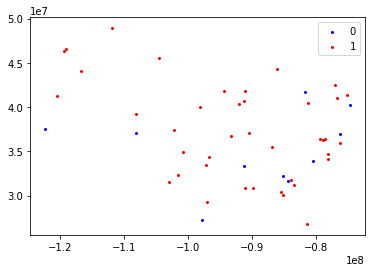

In [20]:
# Import the required modules, plot the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

scatter_x = np.array(list(map(lambda x: x[1:2][0], scd.data)))
scatter_y = np.array(list(map(lambda x: x[:1][0], scd.data)))
group = np.array(list(map(lambda x: x[2:3][0], scd.data)))
cdict = {0: "blue", 1: "red"}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 4)
ax.legend()
plt.show()
